In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('grocerywebsiteabtestdata.csv')

In [6]:
data.shape

(184588, 5)

In [7]:
data.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [8]:
data[data['IP Address'].duplicated()]

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
275,276,191.4.97.7,0,2,0
394,395,79.9.70.7,1,3,0
703,704,175.1.81.8,1,3,0
809,810,125.0.30.9,1,2,0
889,890,207.14.157.6,1,3,0
...,...,...,...,...,...
184582,184583,90.4.224.4,0,3,0
184583,184584,114.8.104.1,0,1,0
184585,184586,170.13.31.9,0,2,0
184586,184587,195.14.92.3,0,3,0


In [9]:
data = data.groupby(['IP Address','LoggedInFlag','ServerID'])['VisitPageFlag'].sum().reset_index(name='sum_visitpage')

In [11]:
data[data['IP Address'].duplicated()]

,IP Address,LoggedInFlag,ServerID,sum_visitpage
561,1.2.21.1,1,2,0
732,1.9.9.2,1,3,0
1265,100.14.254.4,1,3,0
1776,101.3.242.6,1,1,0
2095,102.14.233.2,1,1,0
...,...,...,...,...
98056,95.4.52.4,1,3,0
98260,96.11.211.6,1,2,0
98443,96.3.67.9,1,2,0
98521,96.7.173.7,1,2,0


In [12]:
data = data[data['LoggedInFlag'] != 1]

In [13]:
data['group'] = data['ServerID'].map({1:'Treatment', 2:'Control', 3:'Control'})

In [14]:
data

,IP Address,LoggedInFlag,ServerID,sum_visitpage,group
0,0.0.108.2,0,1,0,Treatment
2,0.0.111.8,0,3,0,Control
4,0.0.163.1,0,2,0,Control
7,0.0.181.9,0,1,1,Treatment
11,0.0.20.3,0,1,0,Treatment
...,...,...,...,...,...
99746,99.9.206.2,0,1,0,Treatment
99748,99.9.215.4,0,3,1,Control
99759,99.9.65.2,0,2,0,Control
99761,99.9.86.3,0,1,1,Treatment


In [15]:
data['visited'] = data['sum_visitpage'].apply(lambda x: 1 if x != 0 else 0)

In [16]:
data.head()

,IP Address,LoggedInFlag,ServerID,sum_visitpage,group,visited
0,0.0.108.2,0,1,0,Treatment,0
2,0.0.111.8,0,3,0,Control,0
4,0.0.163.1,0,2,0,Control,0
7,0.0.181.9,0,1,1,Treatment,1
11,0.0.20.3,0,1,0,Treatment,0


## Statistics

In [17]:
data.groupby(['group','visited']).count()

IP Address  LoggedInFlag  ServerID  sum_visitpage
group     visited                                                   
Control   0             26839         26839     26839          26839
          1              6131          6131      6131           6131
Treatment 0             12696         12696     12696          12696
          1              3847          3847      3847           3847

In [18]:
print(data['sum_visitpage'].mean())

0.2169127299901036


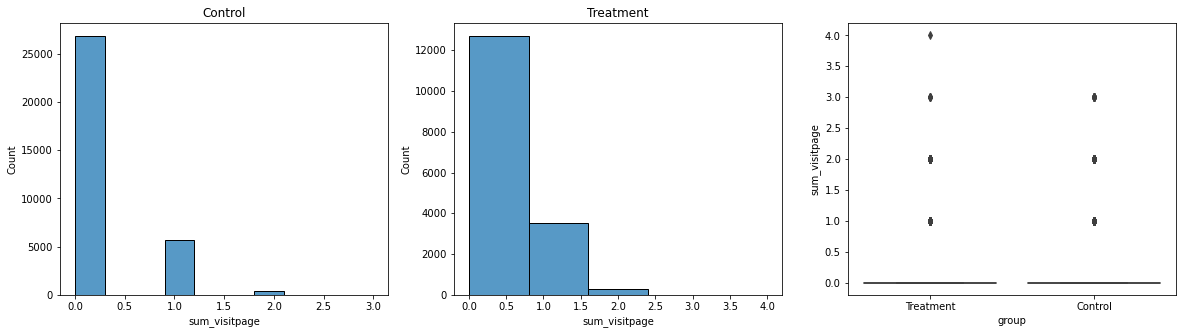

In [19]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)
sns.histplot(data=data[data['group'] == 'Control'], x='sum_visitpage', bins=10, ax=ax[0])
sns.histplot(data=data[data['group'] == 'Treatment'], x='sum_visitpage', bins=5, ax=ax[1])
sns.boxplot(data=data, x='group', y ='sum_visitpage', ax=ax[2])
ax[0].set_title('Control')
ax[1].set_title('Treatment')
plt.show()

In [20]:
data.shape[0]

49513

## Sampling Distribution

In [21]:
means_diff = []
size =int(data.shape[0])

for _ in range(1000):
    sample = data.sample(size, replace=True)
    control_mean = sample[sample['group'] == 'Control']['sum_visitpage'].mean()
    treat_mean = sample[sample['group'] == 'Treatment']['sum_visitpage'].mean()
    differ_mean = control_mean - treat_mean
    means_diff.append(differ_mean)

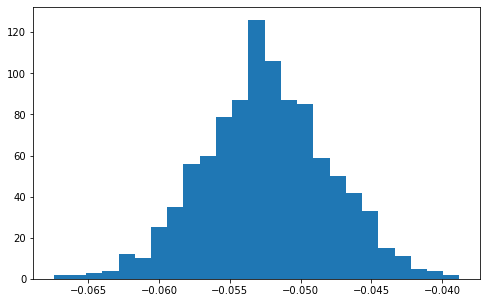

In [22]:
plt.figure(figsize=(8,5))
plt.hist(means_diff, bins=25)
plt.show()

In [25]:
means_diff = np.array(means_diff)
null_vals = np.random.normal(0, means_diff.std(), means_diff.size)

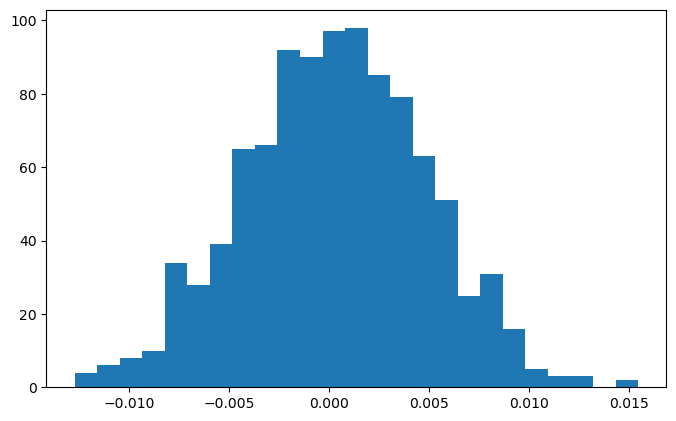

In [26]:
plt.figure(figsize=(8,5), dpi=100)
plt.hist(null_vals, bins=25)
plt.show()

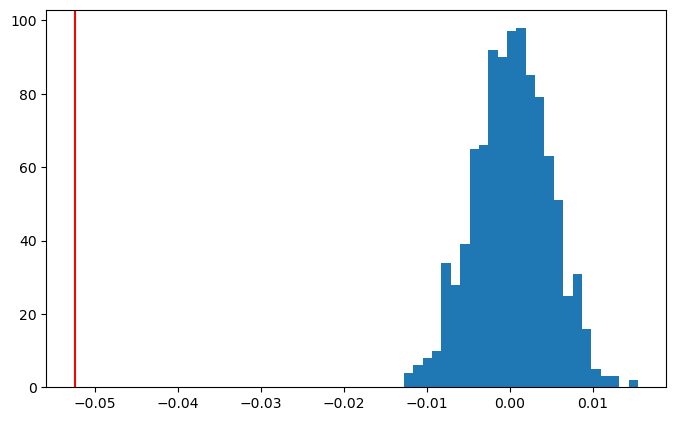

In [27]:
control_mean = data[data['group'] == 'Control']['sum_visitpage'].mean()
treat_mean = data[data['group'] == 'Treatment']['sum_visitpage'].mean()
obs_diff = control_mean - treat_mean

plt.figure(figsize=(8,5), dpi=100)
plt.hist(null_vals, bins=25)
plt.axvline(obs_diff, c='red')
plt.show()

In [28]:
control_mean, treat_mean

(0.19939338792841976, 0.2518285679743698)

In [29]:
obs_diff

-0.05243518004595005

# A/B Testing

In [30]:
groupA = data[data['group'] == 'Control']['sum_visitpage']
groupB = data[data['group'] == 'Treatment']['sum_visitpage']

In [31]:
ntA = shapiro(groupA)[1] < 0.05
ntB = shapiro(groupB)[1] < 0.05
print(f'ntA: {ntA}')
print(f'ntB: {ntB}')

ntA: True
ntB: True


In [32]:
ttest = stats.mannwhitneyu(groupA, groupB)[1]
print(ttest)

5.095496855326828e-35
